# Identificador de especies arbóreas de Costa Rica.
## Utilizando redes convolucionales artificiales

Se utilizará la arquitectura ViT: Vision Transformer

A continuación se entrenará un modelo por completo

# Instalación de paquetes necesarios

In [17]:
import platform
platform.processor()

'x86_64'

In [18]:
#!pip install py-cpuinfo
import cpuinfo
#cpuinfo.get_cpu_info() # all information
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Xeon(R) CPU @ 2.20GHz'

In [19]:
!python --version

Python 3.10.12


In [20]:
import torch
torch.__version__

'2.2.1+cu121'

**torchinfo**: para presentar resumen del modelo

In [23]:
!pip install torchinfo

  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


In [24]:
import torchinfo
torchinfo.__version__

'1.8.0'

In [25]:
import torchvision
torchvision.__version__

'0.17.1+cu121'

# Importación de bibliotecas necesarias

In [ ]:
!pip install gitpython

In [ ]:
import git
import shutil
import os

def clone_git(repo_url, folder, target):
    temp_dir = "temp"
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)

    if os.path.exists(target):
        shutil.rmtree(target)

    repo = git.Repo.clone_from(repo_url, temp_dir)

    source = os.path.join(temp_dir, folder)

    shutil.copytree(source, target)

    shutil.rmtree(temp_dir)

repo_url = 'https://github.com/thechancher/Cocobolo-ViT.git'
folder = 'lib'
target = os.path.join(os.getcwd(), folder)

clone_git(repo_url, folder, target)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Asignación de variables globales

La base de datos que se utilizará es de 1289 imágenes:

66% = 1733 imágenes para el entrenamiento (train)

17% = 446 imágenes para la prueba (test)

18% = 464 imágenes para la validación (validation)

In [26]:
import os

dataset_folder = "drive/MyDrive/Colab Notebooks/dataset-cr"
train_dir = dataset_folder + "/train"
test_dir = dataset_folder + "/test"
validate_dir = dataset_folder + "/validate"

#class_labels = {"1":"1-Aspidosperma polyneuron", "2":"2-Araucaria angustifolia", "3":"3-Tabebuia sp.", "4":"4-Cordia goeldiana", "5":"5-Cordia sp.", "6":"6-Hura crepitans", "7":"7-Acrocarpus fraxinifolius", "8":"8-Hymenaea sp.", "9":"9-Peltogyne sp.", "10":"10-Hymenolobium petraeum", "11":"11-Myroxylon balsamum", "12":"12-Dipteryx sp.", "13":"13-Machaerium sp.", "14":"14-Bowdichia sp.", "15":"15-Mimosa scabrella", "16":"16-Cedrelinga catenaeformis", "17":"17-Goupia glabra", "18":"18-Ocotea porosa", "19":"19-Mezilaurus itauba", "20":"20-Laurus nobilis", "21":"21-Bertholethia excelsa", "22":"22-Cariniana estrellensis", "23":"23-Couratari sp.", "24":"24-Carapa guianensis", "25":"25-Cedrela fissilis", "26":"26-Melia azedarach", "27":"27-Swietenia macrophylla", "28":"28-Brosimum paraense", "29":"29-Bagassa guianensis", "30":"30-Virola surinamensis", "31":"31-Eucalyptus sp.", "32":"32-Pinus sp.", "33":"33-Podocarpus lambertii", "35":"35-Balfourodendron riedelianum", "36":"36-Euxylophora paraensis", "37":"37-Micropholis venulosa", "38":"38-Pouteria pachycarpa", "39":"39-Manilkara huberi", "40":"40-Erisma uncinatum", "41":"41-Vochysia sp."}
class_names_raw = {"10":"10-Spondias mombin [Jobo]","100":"100-Brosimum lactescens [Ojoche blanco, (Ojoche, Ojochillo)]","101":"101-Garcinia madruno [Madruno, Manzana amarilla, (Jorco, Limón de montaña, Madroño)]","102":"102-Dialium guianense [Tamarindo de montaña, (Tamarindo)]","104":"104-Calophyllum brasiliense [Cedro María, María ]","106":"106-Stryphnodendron  microstachyum [Vainillo]","107":"107-Simarouba amara [Aceituno]","113":"113-Hampea appendiculata [Burío, (Algodoncillo, Burío blanco)]","114":"114-Vochysia guatemalensis [Mayo, Cebo, Chancho blanco, (Mayo blanco, Chancho)]","115":"115-Clethra costaricensis [Nance macho]","116":"116-Pourouma bicolor [Chumico]","117":"117-Ilex skutchii [Arenillo, Campano, (Campano blanco)]","118":"118-Inga oerstesiana [Cuajiniquil peludo]","119":"119-Myrsine  pellucidopunctata [Ratón, Ratoncillo]","120":"120-Nectandra membranacea [Aguacatillo, (Quizarrá)]","121":"121-Inga chocoensis [Guabo]","122":"122-Lonchocarpus macrophyllum [Chaperno]","125":"125-Pentaclethra macroloba [Gavilán]","126":"126-Prioria copaifera [Cativo]","127":"127-Chloroleucon sp [Casha]","13":"13-Luehea speciosa [Guácimo molenillo, (Guácimo macho, Guácimo)]","131":"131-Prioria sp. nov [Cativo]","135":"135-Tachigali costaricensis [Tostado]","136":"136-Magnolia gloriensis [Anonillo]","137":"137-Cespedesia spathulata [Tabacón, (Cola de pavo)]","138":"138-Ocotea floribunda [Aguacatillo]","139":"139-Bourreria costaricensis [-]","140":"140-Staphylea occidentalis [Sauco, (Sanlorenzo)]","142":"142-Apeiba membranacea [Peine de mico, Botija]","143":"143-Maranthes panamensis [Pejivallito, (Pejibaye)]","144":"144-Drypetes brownii [Piedrilla]","147":"147-Trichospermum galeottii [Guácimo blanco, (Capulín, Jucó blanco)]","148":"148-Parathesis trichogyne [-]","17":"17-Pochota  fendleri [Pochote, Cedro pochote]","18":"18-Samanea saman [Cenízaro, Genízaro]","2":"2-Cedrela odorata [Cedro amargo]","20":"20-Pachira aquatica [Poponjoche, (Cacao cimarrón, Lirio de agua)]","21":"21-Schizolobium paraibuna [Gallinazo]","23":"23-Tabebuia rosea [Roble de Sabana]","25":"25-Sapium glandulosum [Yos]","27":"27-Brosimum alicastrum [Ojoche, Ramón]","28":"28-Bursera simaruba [Indio desnudo, Jiñocuabe, (Caraña)]","29":"29-Pouteria reticulata [Sapotillo]","3":"3-Cordia alliodora [Laurel]","30":"30-Cassia grandis [Carao, (Sandal)]","31":"31-Trichilia pleeana [-]","43":"43-Brosimum utile [Vaco, Lechoso, (Mastate)]","44":"44-Calophyllum mesoamericanum [Cedro María, María ]","45":"45-Carapa guianensis [Cedro bateo, Cedro macho, Caobilla, (Bateo)]","46":"46-Caryocar costaricense [Ajo, Ajillo]","48":"48-Couratari guianensis [Cachimbo hediondo, Copo hediondo, (Campano Blanco)]","49":"49-Dendropanax arboreus [Fosforillo]","5":"5-Enterolobium cyclocarpum [Guanacaste, (Kurú)]","55":"55-Hieronyma alchorneoides [Pilón, Zapatero, (Sangre de toro)]","57":"57-Jacaranda copaia [Gallinazo, (Jacaranda)]","58":"58-Lacmellea panamensis [Leche de vaca, Lagarto negro]","63":"63-Peltogyne purpurea [Nazareno]","65":"65-Poulsenia armata [Mastate, (Calugo, Chilamate espina)]","7":"7-Diphysa americana [Guachepelín]","70":"70-Pterocarpus sp [Sangrillo]","74":"74-Symphonia globulifera [Cerillo, (Botoncillo)]","75":"75-Tapirira guianensis [Manteco, Cedrillo]","77":"77-Terminalia bucidoides [Escobo, Guayabo de charco, (Roble de charco)]","80":"80-Virola koschnyi [Fruta dorada, Fruta dorada real, (Fruta)]","81":"81-Virola sebifera [-]","82":"82-Vitex cooperi [Manú Platano, Cuajada]","83":"83-Vochysia ferruginea [Botarrama, Mayo colorado, (Mayo)]","84":"84-Vochysia gentryi [Ira de agua, (Mayo)]","85":"85-Zanthoxylum ekmanii [Largarto amarillo, Lagarto, (Lagartillo)]","88":"88-Brosimum costaricanum [Ojoche, (Ojoche macho)]","89":"89-Hymenaea osanigraseminae [Guapinol]","9":"9-Hymenaea courbaril [Guapinol]","93":"93-Astronium graveolens [Ron-ron, (Comenegro)]","94":"94-Pseudolmedia spuria [Ojochillo, Ojochillo colorado, (Guapinolillo, Casanegro)]","99":"99-Pouteria filipes [Sapotillo]"}
#class_names_raw = ["0", "2-Cedrela odorata [Cedro amargo]", "3-Cordia alliodora [Laurel]", "5-Enterolobium cyclocarpum [Guanacaste, (Kurú)]", "7-Diphysa americana [Guachepelín]", "9-Hymenaea courbaril [Guapinol]", "10-Spondias mombin [Jobo]", "13-Luehea speciosa [Guácimo molenillo, (Guácimo macho, Guácimo)]", "17-Pochota  fendleri [Pochote, Cedro pochote]", "18-Samanea saman [Cenízaro, Genízaro]", "20-Pachira aquatica [Poponjoche, (Cacao cimarrón, Lirio de agua)]", "21-Schizolobium paraibuna [Gallinazo]", "23-Tabebuia rosea [Roble de Sabana]", "25-Sapium glandulosum [Yos]", "27-Brosimum alicastrum [Ojoche, Ramón]", "28-Bursera simaruba [Indio desnudo, Jiñocuabe, (Caraña)]", "29-Pouteria reticulata [Sapotillo]", "30-Cassia grandis [Carao, (Sandal)]", "31-Trichilia pleeana [-]", "43-Brosimum utile [Vaco, Lechoso, (Mastate)]", "44-Calophyllum mesoamericanum [Cedro María, María ]", "45-Carapa guianensis [Cedro bateo, Cedro macho, Caobilla, (Bateo)]", "46-Caryocar costaricense [Ajo, Ajillo]", "48-Couratari guianensis [Cachimbo hediondo, Copo hediondo, (Campano Blanco)]", "49-Dendropanax arboreus [Fosforillo]", "55-Hieronyma alchorneoides [Pilón, Zapatero, (Sangre de toro)]", "57-Jacaranda copaia [Gallinazo, (Jacaranda)]", "58-Lacmellea panamensis [Leche de vaca, Lagarto negro]", "63-Peltogyne purpurea [Nazareno]", "65-Poulsenia armata [Mastate, (Calugo, Chilamate espina)]", "70-Pterocarpus sp [Sangrillo]", "74-Symphonia globulifera [Cerillo, (Botoncillo)]", "75-Tapirira guianensis [Manteco, Cedrillo]", "77-Terminalia bucidoides [Escobo, Guayabo de charco, (Roble de charco)]", "80-Virola koschnyi [Fruta dorada, Fruta dorada real, (Fruta)]", "81-Virola sebifera [-]", "82-Vitex cooperi [Manú Platano, Cuajada]", "83-Vochysia ferruginea [Botarrama, Mayo colorado, (Mayo)]", "84-Vochysia gentryi [Ira de agua, (Mayo)]", "85-Zanthoxylum ekmanii [Largarto amarillo, Lagarto, (Lagartillo)]", "88-Brosimum costaricanum [Ojoche, (Ojoche macho)]", "89-Hymenaea osanigraseminae [Guapinol]", "93-Astronium graveolens [Ron-ron, (Comenegro)]", "94-Pseudolmedia spuria [Ojochillo, Ojochillo colorado, (Guapinolillo, Casanegro)]", "99-Pouteria filipes [Sapotillo]", "100-Brosimum lactescens [Ojoche blanco, (Ojoche, Ojochillo)]", "101-Garcinia madruno [Madruno, Manzana amarilla, (Jorco, Limón de montaña, Madroño)]", "102-Dialium guianense [Tamarindo de montaña, (Tamarindo)]", "104-Calophyllum brasiliense [Cedro María, María ]", "106-Stryphnodendron  microstachyum [Vainillo]", "107-Simarouba amara [Aceituno]", "113-Hampea appendiculata [Burío, (Algodoncillo, Burío blanco)]", "114-Vochysia guatemalensis [Mayo, Cebo, Chancho blanco, (Mayo blanco, Chancho)]", "115-Clethra costaricensis [Nance macho]", "116-Pourouma bicolor [Chumico]", "117-Ilex skutchii [Arenillo, Campano, (Campano blanco)]", "118-Inga oerstesiana [Cuajiniquil peludo]", "119-Myrsine  pellucidopunctata [Ratón, Ratoncillo]", "120-Nectandra membranacea [Aguacatillo, (Quizarrá)]", "121-Inga chocoensis [Guabo]", "122-Lonchocarpus macrophyllum [Chaperno]", "125-Pentaclethra macroloba [Gavilán]", "126-Prioria copaifera [Cativo]", "127-Chloroleucon sp [Casha]", "131-Prioria sp. nov [Cativo]", "135-Tachigali costaricensis [Tostado]", "136-Magnolia gloriensis [Anonillo]", "137-Cespedesia spathulata [Tabacón, (Cola de pavo)]", "138-Ocotea floribunda [Aguacatillo]", "139-Bourreria costaricensis [-]", "140-Staphylea occidentalis [Sauco, (Sanlorenzo)]", "142-Apeiba membranacea [Peine de mico, Botija]", "143-Maranthes panamensis [Pejivallito, (Pejibaye)]", "144-Drypetes brownii [Piedrilla]", "147-Trichospermum galeottii [Guácimo blanco, (Capulín, Jucó blanco)]", "148-Parathesis trichogyne [-]"]
print("class_names_raw")
print(class_names_raw)

#class_names = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '35', '36', '37', '38', '39', '4', '40', '41', '5', '6', '7', '8', '9']
class_names = ["10","100","101","102","104","106","107","113","114","115","116","117","118","119","120","121","122","125","126","127","13","131","135","136","137","138","139","140","142","143","144","147","148","17","18","2","20","21","23","25","27","28","29","3","30","31","43","44","45","46","48","49","5","55","57","58","63","65","7","70","74","75","77","80","81","82","83","84","85","88","89","9","93","94","99"]
print("class names")
print(class_names)

print("train classes")
#class_names = os.listdir(train_dir)
print(class_names)

print("test classes")
print(class_names)

print("validation classes")
print(class_names)

model_name = "model-cr-full-10ep.pth"
model_drive = "drive/MyDrive/Colab Notebooks/model"
model_epochs = 10

class_names_raw
{'10': '10-Spondias mombin [Jobo]', '100': '100-Brosimum lactescens [Ojoche blanco, (Ojoche, Ojochillo)]', '101': '101-Garcinia madruno [Madruno, Manzana amarilla, (Jorco, Limón de montaña, Madroño)]', '102': '102-Dialium guianense [Tamarindo de montaña, (Tamarindo)]', '104': '104-Calophyllum brasiliense [Cedro María, María ]', '106': '106-Stryphnodendron  microstachyum [Vainillo]', '107': '107-Simarouba amara [Aceituno]', '113': '113-Hampea appendiculata [Burío, (Algodoncillo, Burío blanco)]', '114': '114-Vochysia guatemalensis [Mayo, Cebo, Chancho blanco, (Mayo blanco, Chancho)]', '115': '115-Clethra costaricensis [Nance macho]', '116': '116-Pourouma bicolor [Chumico]', '117': '117-Ilex skutchii [Arenillo, Campano, (Campano blanco)]', '118': '118-Inga oerstesiana [Cuajiniquil peludo]', '119': '119-Myrsine  pellucidopunctata [Ratón, Ratoncillo]', '120': '120-Nectandra membranacea [Aguacatillo, (Quizarrá)]', '121': '121-Inga chocoensis [Guabo]', '122': '122-Lonchocarpus

# Dimensiones, Patches y Batches

In [27]:
batch_size = 32
image_size = 224
patch_size = 16
rgb = 3
patches = patch_size * patch_size * rgb # 768
# number of patches = 192 = (height * width) / patch^2 = (image_size * image_size) / patch_size ^2
print(patches)

768


# Selección de Tarjeta Gráfica o CPU

In [28]:
import tensorflow as tf

use_cuda = torch.cuda.is_available()
if use_cuda:
  device = "cuda:0"
  print('CUDNN VERSION:', torch.backends.cudnn.version())
  print('Number CUDA Devices:', torch.cuda.device_count())
  print('CUDA Device Name:',torch.cuda.get_device_name(0))
  print('CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
  print('GPU name:', tf.test.gpu_device_name())
else:
  device = "cpu"
  print("No GPU available")

print("Device:", device)

CUDNN VERSION: 8906
Number CUDA Devices: 1
CUDA Device Name: NVIDIA L4
CUDA Device Total Memory [GB]: 23.802544128
GPU name: /device:GPU:0
Device: cuda:0


# Trasladar las imágenes a DataLoader para que sea recibido por la red neuronal

In [29]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Turn images into data loaders

  # Train dataset
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  # Test dataset
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [30]:
# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [31]:
# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=batch_size
)

In [ ]:
test_dataloader.dataset

# Check Dataset

torch.Size([3, 224, 224]) tensor(46)


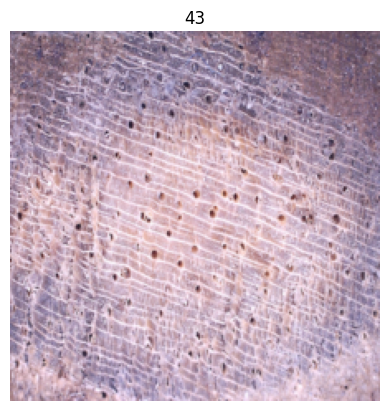

In [33]:
# Let's visualize a image in order to know if data is loaded properly or not
import matplotlib.pyplot as plt

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

32
torch.Size([3, 224, 224])


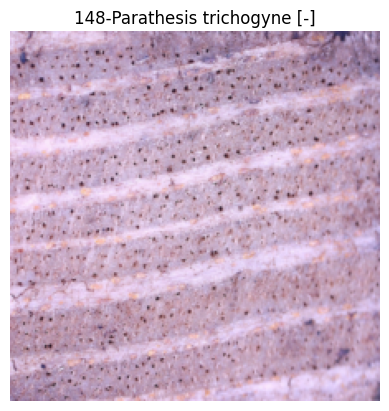

In [34]:
# Let's visualize a image in order to know if data is loaded properly or not

import matplotlib.pyplot as plt
# !pip install numpy
# import numpy
# Get a batch of images
dataset_t = train_dataloader.dataset
#random_index = int(numpy.random.random()*len(dataset_t))
#random_index = 1106 # must be: 48-Couratari guianensis [Cachimbo hediondo, Copo hediondo, (Campano Blanco)]
random_index = 593 # must be: 148-Parathesis trichogyne [-]
random_example, random_label = dataset_t[random_index]
print(random_label)
print(random_example.shape)

# Plot image with matplotlib
plt.imshow(random_example.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names_raw[class_names[random_label]])
plt.axis(False);


## Preparación

1.1 convertir la imagen en patches

1.2 aplanar los patches en una dimensión

1.3 convertir la salida

In [35]:
from torch import nn

In [36]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size, # no overlapping
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [37]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=rgb,
                          patch_size=patch_size,
                          embedding_dim=patches)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [38]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4784,  0.1146, -0.0861,  ...,  0.3953, -0.2222,  0.2589],
         [-0.3668,  0.1218, -0.1343,  ...,  0.4044, -0.3154,  0.2465],
         [-0.5593,  0.0964, -0.1418,  ...,  0.4699, -0.2263,  0.1920],
         ...,
         [-0.7637,  0.2248, -0.2506,  ...,  0.5974, -0.3549,  0.3127],
         [-0.7587,  0.1874, -0.2277,  ...,  0.5918, -0.3615,  0.3061],
         [-0.7435,  0.1524, -0.1219,  ...,  0.4766, -0.3802,  0.2791]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [39]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # test = torch.randm(...)
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4784,  0.1146, -0.0861,  ...,  0.3953, -0.2222,  0.2589],
         [-0.3668,  0.1218, -0.1343,  ...,  0.4044, -0.3154,  0.2465],
         ...,
         [-0.7637,  0.2248, -0.2506,  ...,  0.5974, -0.3549,  0.3127],
         [-0.7587,  0.1874, -0.2277,  ...,  0.5918, -0.3615,  0.3061],
         [-0.7435,  0.1524, -0.1219,  ...,  0.4766, -0.3802,  0.2791]]],
       grad_fn=<CatBackward0>)


# Capa: Transformer Encoder

## MultiHeadAttention

In [40]:
# 1. Create a class that inherits from nn.Module
class MultiHeadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

## MLP block

In [41]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """
    Creates a layer normalized MultiLayer Perceptron block ("MLP block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

## Unir sub-blocks

In [42]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """
    Creates a Transformer Encoder block.
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

## Resumen

In [43]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Construcción del ViT

In [44]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """
    Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

# Entrenar la red usando el dataloader

In [45]:
# Train our Model

# Create an instance of ViT with the number of classes we're working
vit = ViT(num_classes=len(class_names))

In [46]:
from lib import engine

import time
start_time = time.time()

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
training_results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=model_epochs,
                       device=device)

elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6935 | train_acc: 0.0301 | test_loss: 4.6500 | test_acc: 0.0223
Epoch: 2 | train_loss: 4.5670 | train_acc: 0.0233 | test_loss: 4.5805 | test_acc: 0.0134
Epoch: 3 | train_loss: 4.5129 | train_acc: 0.0324 | test_loss: 4.4496 | test_acc: 0.0223
Epoch: 4 | train_loss: 4.3895 | train_acc: 0.0278 | test_loss: 4.4291 | test_acc: 0.0223
Epoch: 5 | train_loss: 4.3491 | train_acc: 0.0295 | test_loss: 4.3759 | test_acc: 0.0246
Epoch: 6 | train_loss: 4.2940 | train_acc: 0.0312 | test_loss: 4.3111 | test_acc: 0.0223
Epoch: 7 | train_loss: 4.2887 | train_acc: 0.0324 | test_loss: 4.3057 | test_acc: 0.0246
Epoch: 8 | train_loss: 4.2808 | train_acc: 0.0301 | test_loss: 4.2983 | test_acc: 0.0246
Epoch: 9 | train_loss: 4.2756 | train_acc: 0.0409 | test_loss: 4.2998 | test_acc: 0.0246
Epoch: 10 | train_loss: 4.2857 | train_acc: 0.0386 | test_loss: 4.3029 | test_acc: 0.0246
Execution time: 00:06:40


In [47]:
# export the model
torch.save(vit, model_name)
shutil.copy2(model_name, model_drive)

'drive/MyDrive/Colab Notebooks/model/model-cr-full-10ep.pth'

# Graficas de error

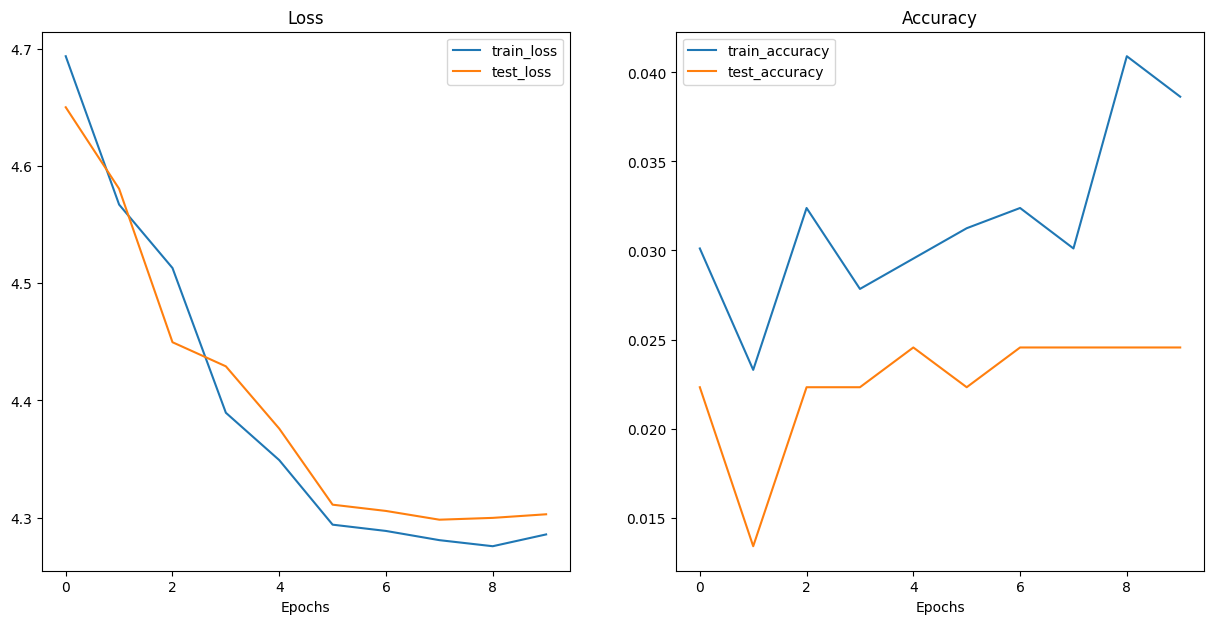

In [48]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from lib.helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(training_results)

# Preparación de prueba del ViT

In [49]:
# Setup custom image path
class_test = "17"
file_test = "3656"
test_dir = validate_dir + "/" + class_test + "/" + file_test + ".jpg"

# Ejecutar predicción usando el modelo entrenado

In [ ]:
#import requests

# Import function to make predictions on images and plot them
#from lib.predictions import pred_and_plot_image

# Predict on custom image
#pred_and_plot_image(model=training_results,
#                    image_path=test_dir,
#                    class_names=class_names)

# Ejecutar predicción usando el modelo entrenado exportado

In [ ]:
import os
import shutil

model_name = "model-cr-full-10ep-02.pth"
model_source = os.path.join(model_drive, model_name)
shutil.copy2(model_source, model_name)

Class:
17

Probability
tensor(0.0195, device='cuda:0')

Probabilities
tensor([[0.0142, 0.0123, 0.0126, 0.0123, 0.0131, 0.0127, 0.0125, 0.0131, 0.0147,
         0.0123, 0.0127, 0.0125, 0.0135, 0.0128, 0.0127, 0.0130, 0.0132, 0.0119,
         0.0120, 0.0119, 0.0121, 0.0133, 0.0130, 0.0128, 0.0127, 0.0128, 0.0126,
         0.0126, 0.0125, 0.0121, 0.0128, 0.0129, 0.0123, 0.0195, 0.0134, 0.0160,
         0.0123, 0.0165, 0.0144, 0.0134, 0.0140, 0.0130, 0.0121, 0.0123, 0.0127,
         0.0126, 0.0127, 0.0154, 0.0146, 0.0154, 0.0134, 0.0125, 0.0134, 0.0144,
         0.0148, 0.0150, 0.0149, 0.0124, 0.0140, 0.0118, 0.0156, 0.0151, 0.0131,
         0.0127, 0.0137, 0.0121, 0.0140, 0.0150, 0.0146, 0.0127, 0.0121, 0.0122,
         0.0138, 0.0135, 0.0125]], device='cuda:0')

Sorted:
sorted: torch.return_types.sort(
values=tensor([[0.0195, 0.0165, 0.0160, 0.0156, 0.0154, 0.0154, 0.0151, 0.0150, 0.0150,
         0.0149, 0.0148, 0.0147, 0.0146, 0.0146, 0.0144, 0.0144, 0.0142, 0.0140,
         0.0140, 0.

[{'index': 33,
  'name': '17',
  'label': '17-Pochota  fendleri [Pochote, Cedro pochote]',
  'prob': 0.019483689218759537},
 {'index': 37,
  'name': '21',
  'label': '21-Schizolobium paraibuna [Gallinazo]',
  'prob': 0.016517866402864456},
 {'index': 35,
  'name': '2',
  'label': '2-Cedrela odorata [Cedro amargo]',
  'prob': 0.015993203967809677},
 {'index': 60,
  'name': '74',
  'label': '74-Symphonia globulifera [Cerillo, (Botoncillo)]',
  'prob': 0.015581483021378517},
 {'index': 47,
  'name': '44',
  'label': '44-Calophyllum mesoamericanum [Cedro María, María ]',
  'prob': 0.015420019626617432}]

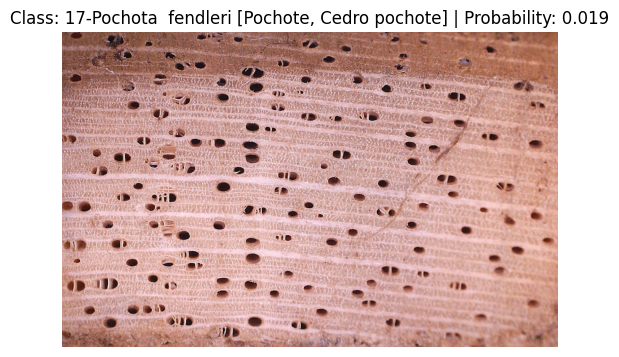

In [50]:
import torch
# import requests

# Import function to make predictions on images and plot them
from lib.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = test_dir
model = torch.load(model_name)
model.eval()

# Predict on custom image
# must be: 'index': 33, 'name': '17', 'label': '17-Pochota  fendleri [Pochote, Cedro pochote]'
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    class_labels=class_names_raw)